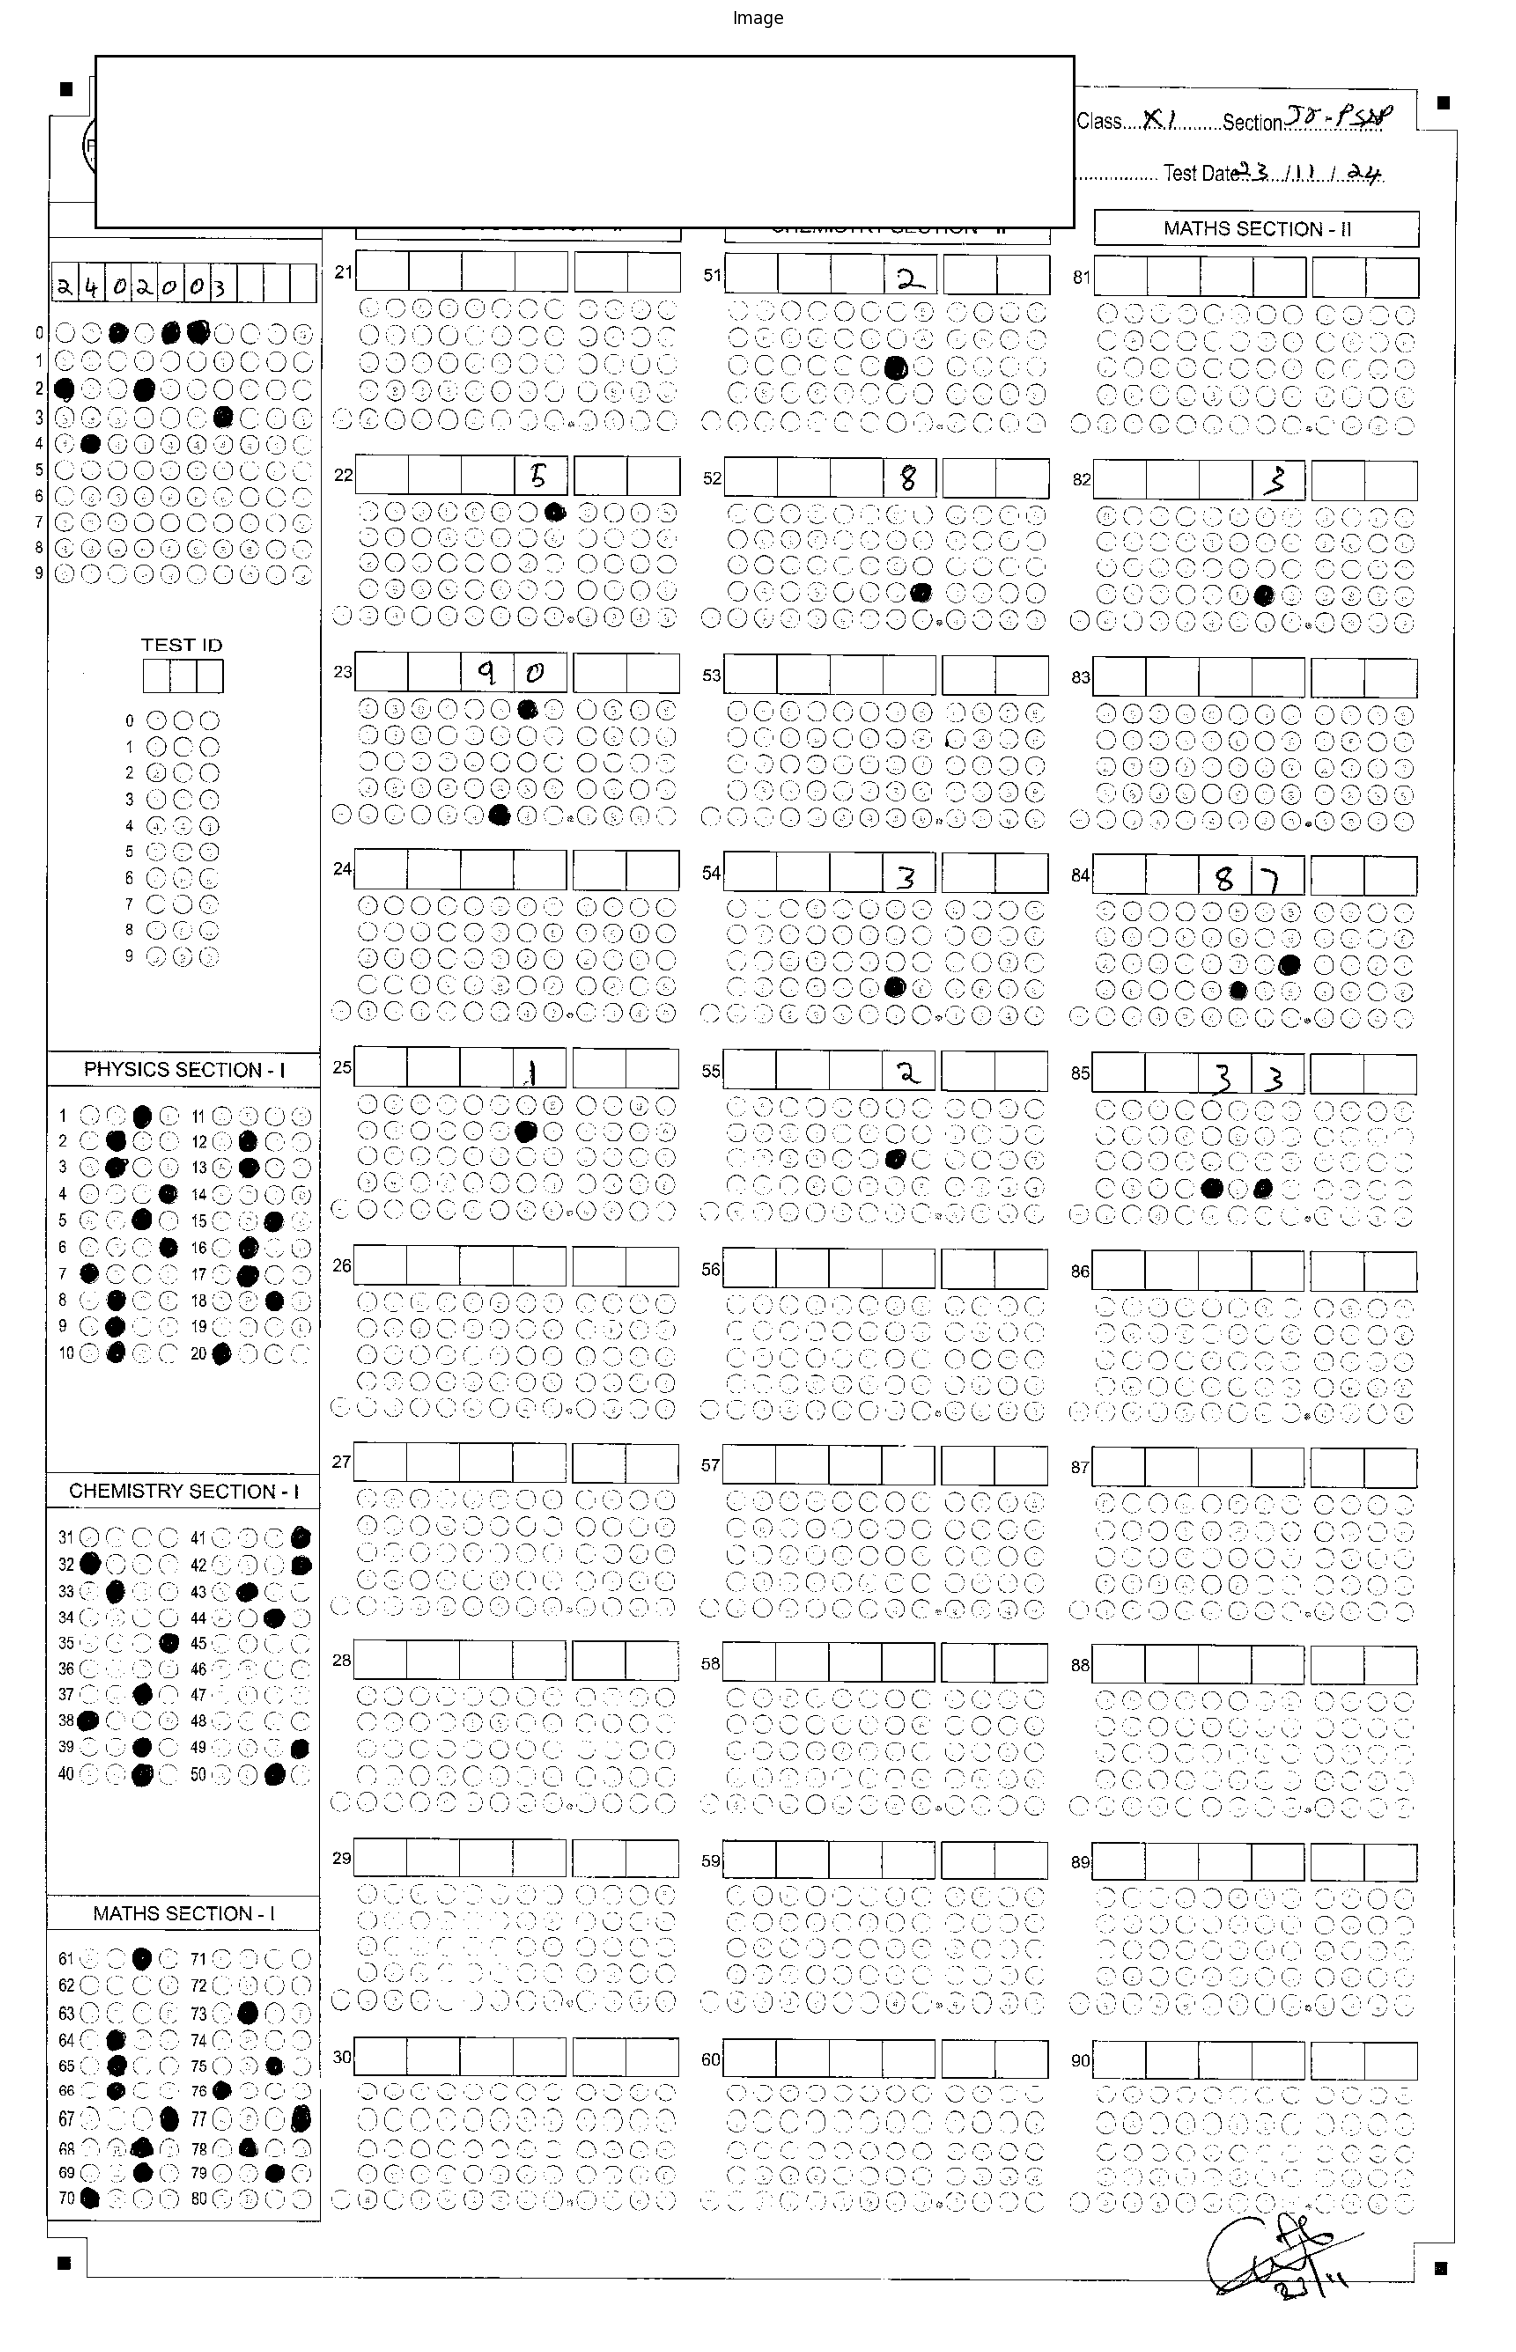

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

def show_image(img, title='Image', cmap_type='gray'):
    plt.figure(figsize=(40, 30))
    plt.imshow(img, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image in grayscale
image = cv2.imread('./OMR_dataset/images/omr_aiml_dataset_page_6.png', cv2.IMREAD_GRAYSCALE)

# Perform Canny Edge Detection without blur
edges_without_blur = cv2.Canny(image, 50, 150)

# Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(image, (5, 5), 3)

# Compute Otsu's threshold
otsu_thresh, thresh_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

show_image(thresh_image)


In [ ]:
import cv2
import numpy as np

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute the width and height of the new image
    width_a = np.linalg.norm(br - bl)
    width_b = np.linalg.norm(tr - tl)
    max_width = max(int(width_a), int(width_b))

    height_a = np.linalg.norm(tr - br)
    height_b = np.linalg.norm(tl - bl)
    max_height = max(int(height_a), int(height_b))

    # Destination points
    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype="float32")

    # Perspective transformation
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

# Load image
image = cv2.imread('./OMR_dataset/images/omr_aiml_dataset_page_6.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Preprocess the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Approximate the largest contour
for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

    if len(approx) == 4:  # If a quadrilateral is found
        screen_contour = approx
        break

# Perform perspective transform if a quadrilateral is detected
if 'screen_contour' in locals():
    warped = four_point_transform(image, screen_contour.reshape(4, 2))

    # Display results
    cv2.imshow("Original Image", image)
    cv2.imshow("Warped Image", warped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No quadrilateral detected.")
